# Staying  home

What percentage of daily users stayed home? 

How does this differ over time? And by Parish?


In [1]:
import datetime
import pathlib

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd


IMSI = 'imsi'
PARISH = 'parish'
HOME_PARISH = 'home parish'
DATE = 'date'

USERS = 'users'
STAY_HOME_USERS = 'stay home users'
DAY_USERS = 'day users'
PORTION_STAY_HOME_USERS = 'portion of people staying home'
PERCENT_STAY_HOME_USERS = '(%) Users staying home'

date_fmt = '%Y-%m-%d'


parishes = ['Andorra la Vella', 'Canillo', 'Encamp', 'Escaldes-Engordany',
            'La Massana', 'Ordino', 'Sant Julià de Lòria']

In [2]:
DATA_FILEPATH = '../data/private/'


def get_homes_filepath(year, month):
    return '{}homes/{}_{}_homes.csv'.format(DATA_FILEPATH, year, month)

def get_stays_filepath(day, month, year):
    return '{}stays/{}_{}/stays_{}_{}_{}.csv'.format(DATA_FILEPATH, year, month, year, month, day)

def daterange(start_datetime, end_datetime):
    for n in range(int((end_datetime - start_datetime).days) + 1):
        yield start_datetime + datetime.timedelta(n)

In [40]:
start_date_2019 = '2019-03-01'
end_date_2019 = '2019-10-31'

start_date_2020 = '2020-03-01'
end_date_2020 = '2020-10-31'

dates_2019 = [d for d in daterange(datetime.datetime.strptime(start_date_2019, date_fmt), 
                                   datetime.datetime.strptime(end_date_2019, date_fmt))]
dates_2020 = [d for d in daterange(datetime.datetime.strptime(start_date_2020, date_fmt), 
                                   datetime.datetime.strptime(end_date_2020, date_fmt))]
# dates_2019

In [3]:
PRESENCE_TOURISTS_FPATH = DATA_FILEPATH+'presence/2020/presence_tourists.csv'
PRESENCE_OTHERS_FPATH = DATA_FILEPATH+'presence/2020/presence_others.csv'

In [42]:
# Avoid storing multiple huge dataframes in memory

def read_presence_csv(fpath):
    return pd.read_csv(fpath).rename(columns={'Unnamed: 0': IMSI}).set_index(IMSI)

presence_df = read_presence_csv(PRESENCE_TOURISTS_FPATH)
print('%s tourists with presence data' % len(presence_df))
presence_df = presence_df.append(read_presence_csv(PRESENCE_OTHERS_FPATH))
print('%s total users with presence data' % len(presence_df))

1215417 tourists with presence data
1288799 total users with presence data


Make a table:
```
day, parish, users,  stay home users
```

where users is the number of users inferred present

In [124]:
df = None
month_user_homes = None
def get_day_parish_df(dates, presence_df):
    month = None
    month_user_homes =  None
    records = []
    missing_dates = []
    for i, d in enumerate(dates):
        date_str =  d.strftime("%Y-%m-%d")
        if i % 50 == 0:
            print('%s/%s %s' %  (i, len(dates), date_str))
        if month != d.month:
            month_user_homes = pd.read_csv(get_homes_filepath(d.year, d.month))[
                [IMSI, PARISH]
            ].set_index(IMSI)[PARISH]
            month = d.month
        stays_filepath = get_stays_filepath(d.day, d.month, d.year)
        if not pathlib.Path(stays_filepath).is_file():
            print('%s\nfile not found: %s' % (date_str, stays_filepath))
            missing_dates += [d]
            for p in parishes:
                records += [{
                    DATE: d,
                    PARISH: p,
                    DAY_USERS: np.NaN,
                    USERS: np.NaN,
                    STAY_HOME_USERS: np.NaN,
                }]
            continue
            
        df = pd.read_csv(stays_filepath)[[IMSI, PARISH]]
        # limit data to users in the homes data and add their home parish
        df[HOME_PARISH] = df[IMSI].map(month_user_homes)
        df = df.dropna()
        
        # compute daily stay home users as
        # stay home users = users - non_stay_home_users
        # where non_stay_home_users = (users with (> 1 stay | stay outside home parish)

        # get users with stays outside home parish
        users_w_stays_outside_home_set = set(df[df[PARISH]!=df[HOME_PARISH]][IMSI])
        # get users with more than one stay
        multiple_stays_users = (df[IMSI].value_counts() > 1) # maps IMSI -> boolean
        multiple_stays_users_set = set(multiple_stays_users[multiple_stays_users].index)
        # get set of users with more than one stay OR a stay outside home parish
        non_stay_home_users_set = multiple_stays_users_set.union(users_w_stays_outside_home_set)
        # make user homes map restricted to non stay home users: non_stay_home_users --> home parish
        non_stay_home_users_homes_map = month_user_homes[non_stay_home_users_set]
        
        imsis_present = presence_df[presence_df[date_str]>0].index.intersection(month_user_homes.index)
        parish_presence_counts = month_user_homes[imsis_present].value_counts()
        
        # By parish
        for p in parishes:
            p_users = parish_presence_counts[p]
            day_parish_record = {
                DATE: d,
                PARISH: p,
                USERS: p_users,
                STAY_HOME_USERS: p_users - len(non_stay_home_users_homes_map[month_user_homes==p]),
            }
            records += [day_parish_record]
    days_df = pd.DataFrame.from_records(records)
    return days_df, missing_dates

In [125]:
days_df, missing_dates = get_day_parish_df(dates_2020, presence_df)

0/245 2020-03-01
2020-03-01
file not found: /home/data_commons/andorra_data_2020/stays/2020_3/stays_2020_3_1.csv
50/245 2020-04-20
100/245 2020-06-09
2020-06-28
file not found: /home/data_commons/andorra_data_2020/stays/2020_6/stays_2020_6_28.csv
2020-06-29
file not found: /home/data_commons/andorra_data_2020/stays/2020_6/stays_2020_6_29.csv
2020-07-21
file not found: /home/data_commons/andorra_data_2020/stays/2020_7/stays_2020_7_21.csv
2020-07-22
file not found: /home/data_commons/andorra_data_2020/stays/2020_7/stays_2020_7_22.csv
2020-07-23
file not found: /home/data_commons/andorra_data_2020/stays/2020_7/stays_2020_7_23.csv
2020-07-24
file not found: /home/data_commons/andorra_data_2020/stays/2020_7/stays_2020_7_24.csv
2020-07-25
file not found: /home/data_commons/andorra_data_2020/stays/2020_7/stays_2020_7_25.csv
2020-07-26
file not found: /home/data_commons/andorra_data_2020/stays/2020_7/stays_2020_7_26.csv
2020-07-27
file not found: /home/data_commons/andorra_data_2020/stays/2020

In [126]:
days_df.head(20)

,date,parish,day users,users,stay home users
0,2020-03-01,Andorra la Vella,NaN,NaN,NaN
1,2020-03-01,Canillo,NaN,NaN,NaN
2,2020-03-01,Encamp,NaN,NaN,NaN
3,2020-03-01,Escaldes-Engordany,NaN,NaN,NaN
4,2020-03-01,La Massana,NaN,NaN,NaN
5,2020-03-01,Ordino,NaN,NaN,NaN
6,2020-03-01,Sant Julià de Lòria,NaN,NaN,NaN
7,2020-03-02,Andorra la Vella,NaN,21415.0,5198.0
8,2020-03-02,Canillo,NaN,13954.0,3326.0
9,2020-03-02,Encamp,NaN,8865.0,1343.0


In [127]:
days_df[PORTION_STAY_HOME_USERS] = days_df[STAY_HOME_USERS]/days_df[USERS]
days_df[PERCENT_STAY_HOME_USERS] = 100*days_df[PORTION_STAY_HOME_USERS]

days_df.sort_values(DATE, ascending=False).head()

,date,parish,day users,users,stay home users,portion of people staying home,(%) Users staying home
1714,2020-10-31,Sant Julià de Lòria,NaN,7414.0,2590.0,0.349339,34.933909
1713,2020-10-31,Ordino,NaN,3529.0,1403.0,0.397563,39.756305
1712,2020-10-31,La Massana,NaN,7945.0,2930.0,0.368785,36.878540
1711,2020-10-31,Escaldes-Engordany,NaN,8457.0,3883.0,0.459146,45.914627
1710,2020-10-31,Encamp,NaN,6888.0,2316.0,0.336237,33.623693


Plot it.

Text(0, 0.5, '(%) Percent of daily subscribers staying home')

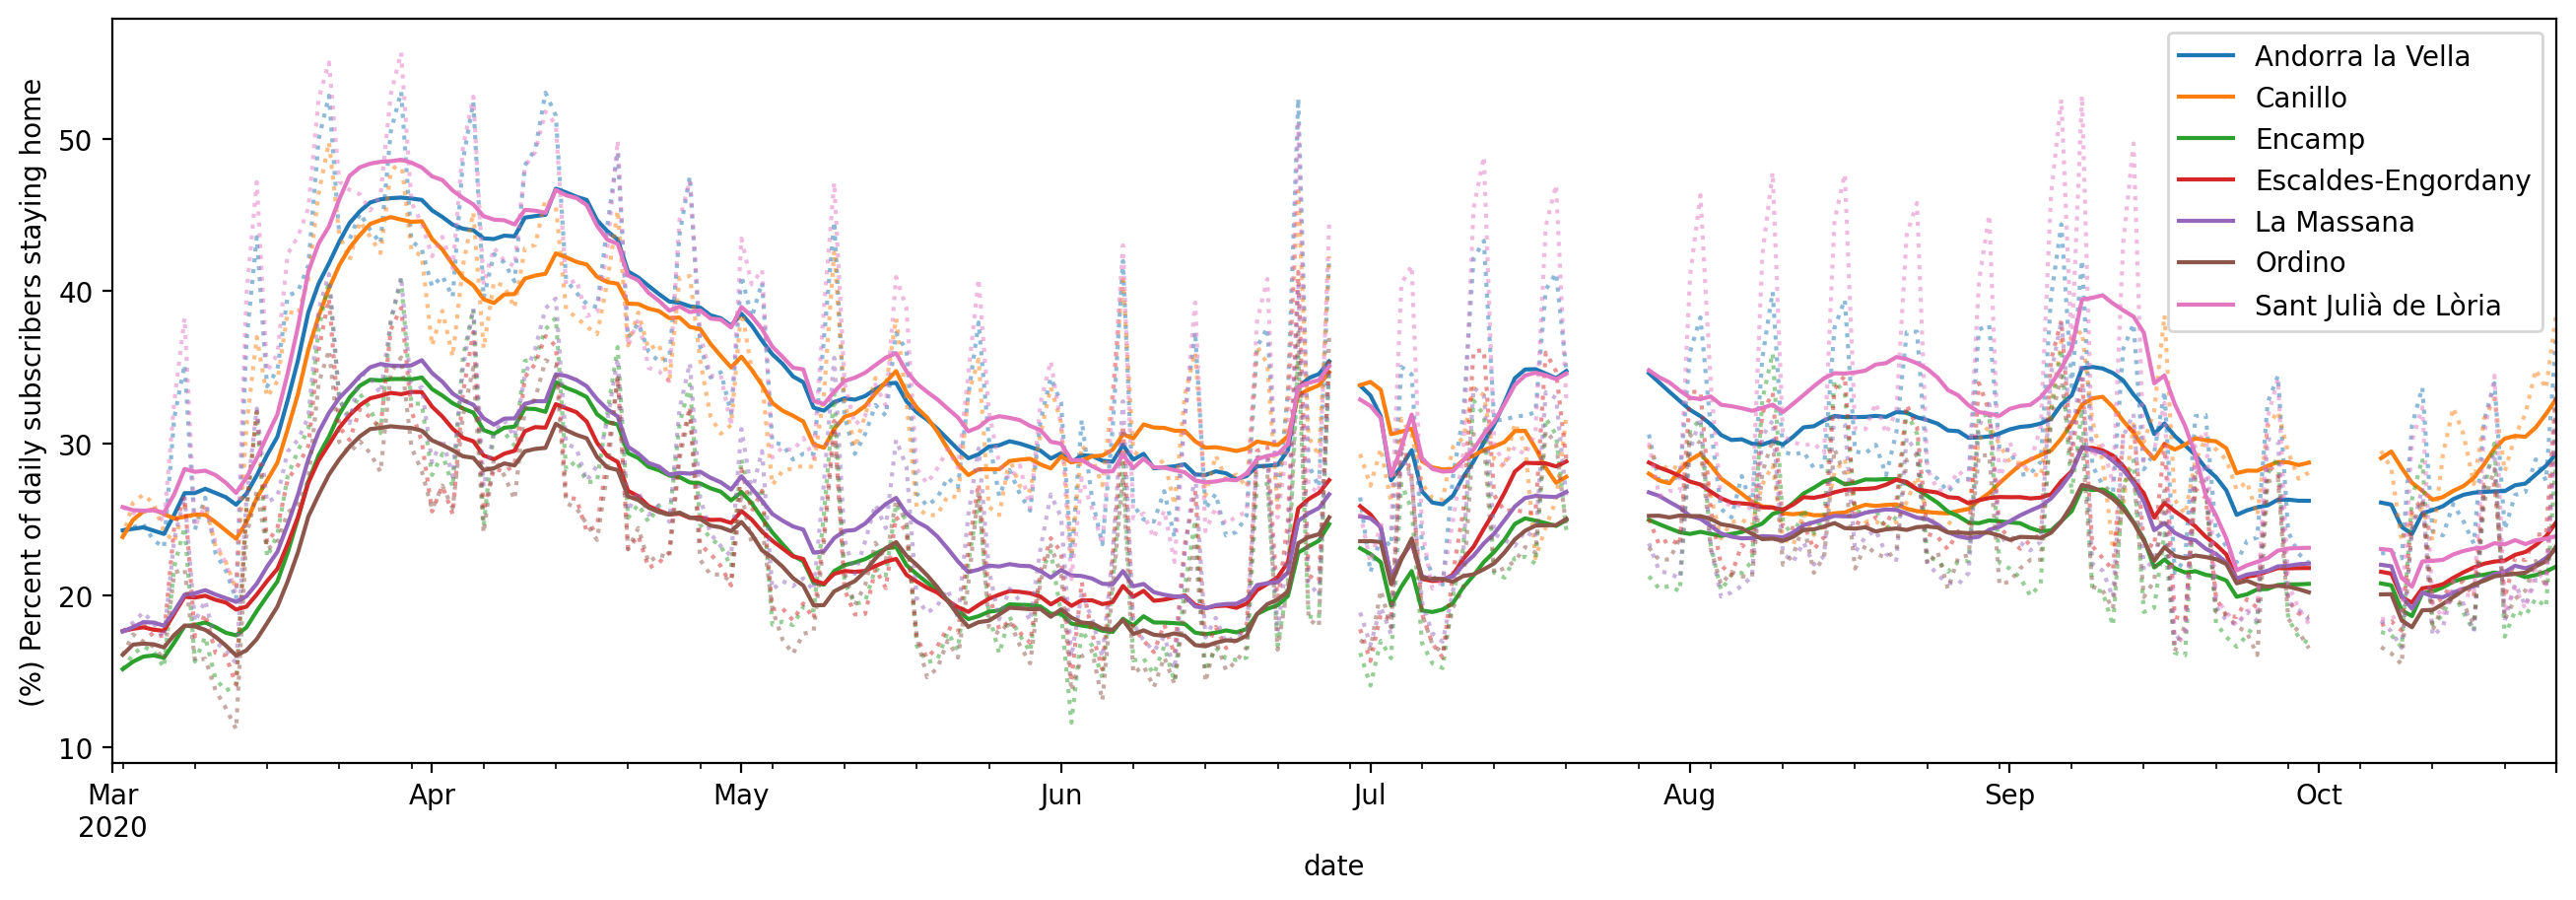

In [142]:
cmap = plt.get_cmap("tab10")
parish_cmap = {sorted(parishes)[i]:cmap(i) for i in range(len(parishes))}

fig, ax= plt.subplots(1, figsize=(16, 5), dpi=100)

p_series = None
for p in parishes:
    p_series = days_df[days_df[PARISH]==p].set_index(DATE).reindex(dates_2020).loc[:'2020-10-24',]
    index = p_series.index
    p_series[PERCENT_STAY_HOME_USERS].plot(label='_nolegend_',
        ax=ax, color=parish_cmap[p], alpha=0.5, linestyle='dotted')
    p_series[PERCENT_STAY_HOME_USERS].dropna().rolling(7, min_periods=1).mean().reindex(index).plot(
        label='%s'%p,
        ax=ax, color=parish_cmap[p], legend=True)

ax.set_ylabel('(%) Percent of daily subscribers staying home')